# Практическая работа №2. Реализация слоя особой структуры на базе фреймворка Keras

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from waveletlayer import WaveletLayer, InitTranslationSpace, InitScalesConstant, InitTranslationConstant, InitTranslationRandom
from tensorflow.keras.initializers import Constant
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
import tensorflow.keras
print (tensorflow.keras.__version__)

2.2.4-tf


Вейвлет-сеть представляет собой трёхслойную нейронную сеть, в которой первый слой является входным слоем, второй – скрытым, а третий – выходным. Входной слой служит для ввода в сеть исходных данных. Нейроны скрытого слоя, также называемые вейвлет-нейронами, являются аналогами нейронов с сигмовидной функцией активации в классических нейронных сетях. В скрытом слое входные данные преобразуются с помощью сдвинутого и сжатого материнского вейвлета, и, наконец, в выходном слое формируется выходное значение вейвлет-сети, сравнивающееся затем с целевым значением, а расхождение между ними используется для настройки параметров сети.
Были предложены различные структуры вейвлет-сетей, однако, общая их идея заключается в настройке параметров сжатия и сдвига вейвлет-нейронов для наилучшего обучения данным. 


Выход мультивейвлетной сети определяется уравнением:
 $$\hat{y}(\mathbf{x})=w_{\lambda+1}^{[2]}+\sum_{j=1}^{\lambda}{w_{j}^{[2]}\cdot \mathbf{\Psi}_j(\mathbf{x})}+\sum_{i=1}^m{w_i^{[0]}\cdot x_i},(1)$$
где $\mathbf{\Psi}_j(\mathbf{x})$ – многомерный вейвлет, задающийся как произведение $m$ скалярных вейвлетов,  $x$ – вектор входных данных, $m$ – количество входов, $\lambda$ – количество скрытых вейвлет-нейронов и $w$ – параметры сети: $w^{[2]}_{λ+1}$ – вес смещения, $w_i^{[0]}$ – веса линейных связей , $w_j^{[2]}$ –  веса нелинейных связей.

![title](http://iait.kg/wp-content/uploads/2019/01/Wn-1.png)

 Многомерный вейвлет в формуле (1) вычисляется как
 $$\mathbf{\Psi}(\mathbf{x})=\prod_{i=1}^m\psi(z_{ij}),(2)$$
где $\psi$ – материнский вейвлет, и 
$$z_{ij}=\frac{x_i-w^{[1]}_{(\xi)ij}}{w^{[1]}_{(\zeta)ij}} .					(3)$$
В выражении (3) $i=1, …, m$, $j=1, …, \lambda+1$, $w^{[1]}_{(\xi)ij}$ – параметры сдвигов
и $w^{[1]}_{(\zeta)ij}$ – параметры масштабов вейвлетов.
В качестве материнского обычно используются такие вейвлеты как: 
первая производная Гауссианны т.н. «WAVE-вейвлет»: 
$$\psi(z_{ij})=z_{ij}e^{0.5z^2_{ij}}						 ,				(4)$$
вторая производная Гауссианны т.н. «Мексиканская шляпа»: 
$$ \psi(z_{ij})=(1-z^2_{ij})e^{0.5z^2_{ij}},				(5)$$
или вейвлет Морле:
 $$ \psi(z_{ij})=cos(5z_{ij})e^{0.5z^2_{ij}}	.				(6)$$
Выбор материнского вейвлета зависит о решаемой задачи и не ограничивается приведенными выше функциями.

Ниже представлена реализация вейвлет-сети без линейных связей между входом и выходом.

In [3]:
n=100
X=np.linspace(-1,1,num=n).reshape(n,1) 
y=np.cos(8*X)+np.random.uniform(-0.1,0.1,X.shape)
model = Sequential()
wltlayer = WaveletLayer(20,
                            translation_initializer=InitTranslationSpace(X),
                            scales_initializer=InitScalesConstant(X),
                            input_shape=(1,))
model.add(wltlayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
                  optimizer=RMSprop())
translations = wltlayer.get_weights()[0]
model.fit(X, y,
              batch_size=50,
              epochs=4000,
              verbose=0)



W0309 14:38:40.243326 139891048625920 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0309 14:38:40.939905 139891048625920 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:167: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Вейвлет-сеть с одним входом и одним выдом используется для аппроксимации косинусоиды.

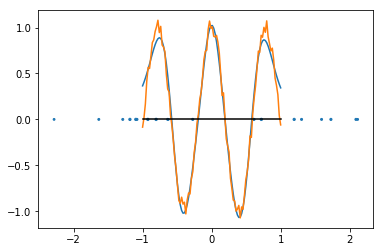

In [4]:
y_pred = model.predict(X)

#print(wltlayer.get_weights())

%matplotlib inline    
plt.plot(X, y_pred)
plt.plot(X, y)
plt.plot([-1,1], [0,0], color='black')
    
translations = wltlayer.get_weights()[0]
scales = wltlayer.get_weights()[1]

plt.scatter(translations, np.zeros(len(translations)), s=20*scales)
    
plt.show()

Ниже показан пример аппроксимации двухмерной косинусоиды вейвлет-сетью со многими входами и двумя выходами.

In [5]:
X = np.arange(-1, 1, 0.1)
Y = np.arange(-1, 1, 0.1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.cos(3*R)+np.random.uniform(-0.1,0.1,R.shape)
x1=X.reshape((X.shape[0]*X.shape[1],1))
x2=Y.reshape((Y.shape[0]*Y.shape[1],1))
inp = np.concatenate((x1,x2),axis=1)
tar = Z.reshape((Z.shape[0]*Z.shape[1],1))
size = Z.shape[0]

In [6]:
model = Sequential()
wltlayer = WaveletLayer(20,
                            translation_initializer=InitTranslationConstant(inp),
                            scales_initializer=InitScalesConstant(inp),
                            input_shape=(2,))
model.add(wltlayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
                  optimizer=RMSprop())

model.fit(inp, tar,
              batch_size=50,
              epochs=500,
              verbose=0)

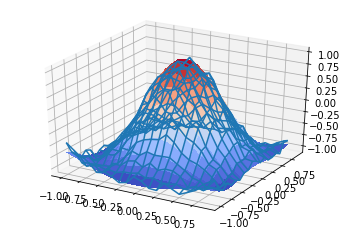

In [7]:
y_pred = model.predict(inp)
o = y_pred.reshape((size, size))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
ax1 = fig.gca(projection='3d')

surf1 = ax.plot_surface(X, Y, o, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
plt.show()


## Задания

Задания должны быть реализованы так как это принято в фреймворке Keras.
1. Добавьте инициализацию весов сети случайными числами, равномерно распределенными в указанном диапазоне.
2. Добавьте реализацию различных функций активации.
3. Добавьте в модель линейные связи между входом и выходом.